In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
import skimage
import tifffile as tiff
import os
import math
import json
from skimage.measure import label
from skimage.measure import regionprops
from com import *
import csv
from tqdm.notebook import tqdm
from skeleton import *


In [2]:
csvpath = "/home/isis0517/Documents/data/20210115/0115-03.csv"
imgspath = "/home/isis0517/Documents/data/20210115/03_id/"
savepath = "/home/isis0517/Documents/data/20210115/"
    

flist = os.listdir(imgspath)
tiflist = []
for filename in flist:
    if os.path.isdir(filename):
        continue
    if filename.split(".")[-1] == "npy" :
        tiflist.append(filename)

print('There is a total of ',len(tiflist), 'images')
frame_num = len(tiflist)
#for srt in os.listdir(path):
#flist.append(srt.split('_'))

#排序路徑
tiflist.sort(key = lambda x: int(x.split("_")[-1].split(".")[0]))

#變成絕對路徑
flist = []
for filename in tiflist:
    flist.append(os.path.join(imgspath, filename))

There is a total of  23423 images


# Generate the background

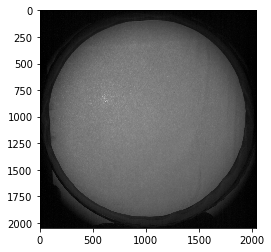

In [15]:
nbckgnd = 500
tnum = np.random.randint(len(flist),size=nbckgnd)
tlist=[]
for s in tnum:
    tlist.append(flist[s])

img_shape = np.load(flist[0]).shape[0:2]
total = np.zeros(img_shape)
for file in tlist:
    b = np.load(file)
    img = cv2.cvtColor(b, cv2.COLOR_BayerBG2GRAY)
    #img = cv2.blur(img)
    total = total + img
background = (total/nbckgnd).astype('uint8')
cbackground = background
shape = img_shape
plt.imshow(background, plt.cm.gray)

In [16]:
img =np.load(flist[0])
size = 120 #cv2.VideoWriter_fourcc(*'MPEG')
video = cv2.VideoWriter(os.path.join(savepath, "path_video03.avi"), cv2.VideoWriter_fourcc(*'MPEG'),
                        40, (size*2+1, size*2+1), isColor=False)

traj = []
cross = []
with open(csvpath, newline='') as csvfile:

  # 讀取 CSV 檔案內容
    rows = csv.reader(csvfile, delimiter=';')

  # 以迴圈輸出每一列
    for s,row in tqdm(enumerate(rows)):
        if s > 0 :
            try:
                pos = (int(row[2]), int(row[1]))
            except Exception as e:
                print(e)
                break
            cross.append(row[3]=='1')
            traj.append(pos)
            img = np.load(flist[s-1])
            img = cv2.cvtColor(img, cv2.COLOR_BayerBG2GRAY)
            img = cv2.absdiff(img, background)
            img = np.where(img>15, 255, 0).astype('uint8')
            img = cutting_img(img, pos, 120)
            video.write(img)
    video.release()
        

In [17]:
img =np.load(flist[0])
shape = img.shape[0:2]

rposes = []
for pos in traj:
    rposes.append((pos[0]/shape[0], pos[1]/shape[1]))
    
np.save("0115-03_trj.npy", rposes
       )

In [ ]:
traj = []
cross = []
with open(csvpath, newline='') as csvfile:

  # 讀取 CSV 檔案內容
    rows = csv.reader(csvfile, delimiter=';')

  # 以迴圈輸出每一列
    for s,row in tqdm(enumerate(rows)):
        if s > 0 :
            try:
                pos = (int(row[2]), int(row[1]))
            except Exception as e:
                print(e)
                break
            cross.append(row[3]=='1')
            traj.append(pos)
            img = np.load(flist[s-1])
            img = cv2.cvtColor(img, cv2.COLOR_BayerBG2GRAY)
            img = cv2.absdiff(img, background)
            img = np.where(img>15, 255, 0).astype('uint8')
            img = cutting_img(img, pos, 120)
            np.save(os.path.join(savepath,"03_id",f"frame_{s:05d}.npy"), img)
    video.release()
        

In [39]:
s=100
print(f"{s:05d}")

00100


In [3]:
rot_imgs=[]
for s, file in tqdm(enumerate(flist)):
    img = np.load(file)
    img = cutting_img(img, (120,120), 100)

    try:
        sks = NT_skeleton(img)
    except:
        continue
    v1 = sks[0]-sks[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    
    #等邀三角只要知道第三邊長c就可以算出角度，但如要知道旋轉的方向則須判別兩向量正負號
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sks)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))>200
    rotated = rotated.flatten()
    rot_imgs.append(rotated)

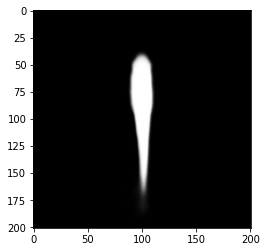

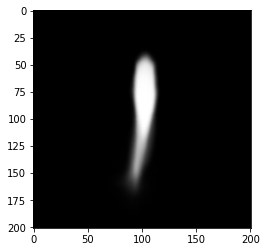

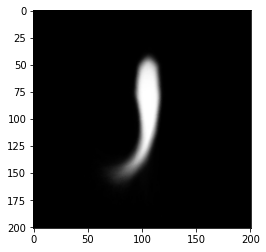

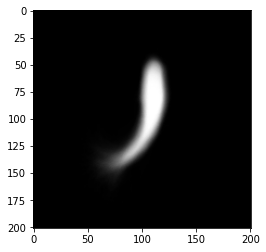

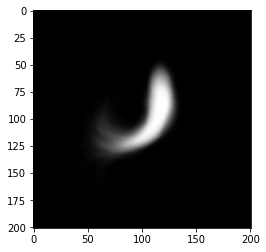

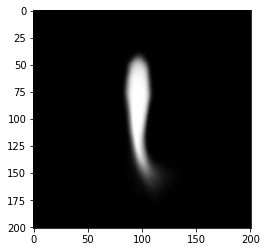

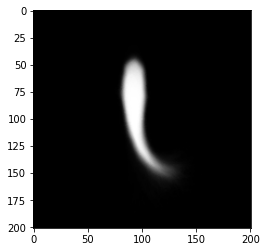

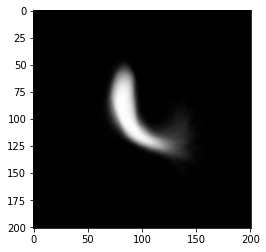

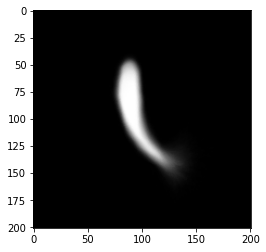

(9, 40401)

In [35]:

init_cen = []
cenlist = os.listdir(os.path.join(savepath, "init_cen"))
cenlist.sort()
for file in cenlist:
    img = cv2.imread(os.path.join(savepath, "init_cen", file), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, plt.cm.gray)
    plt.show()
    init_cen.append(img.flatten()>200)
    
init_cen = np.array(init_cen)
init_cen.shape

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="random", tol=1e-6, n_init=20)
kmeans.fit(rot_imgs)
labels = kmeans.predict(rot_imgs)
centers = kmeans.cluster_centers_

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


0


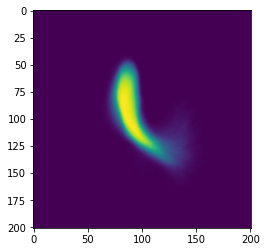

1


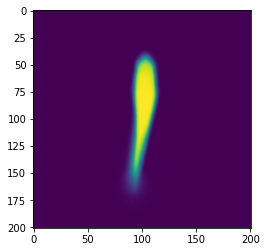

2


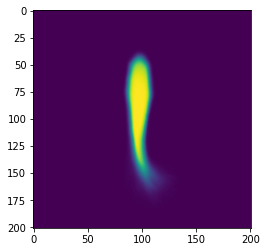

3


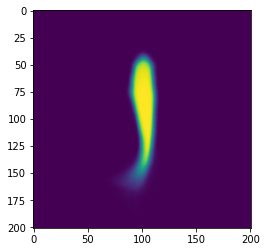

4


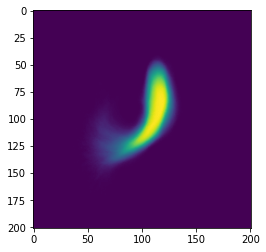

5


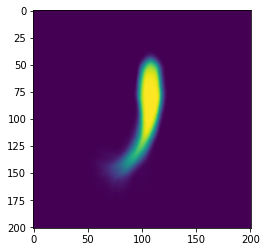

6


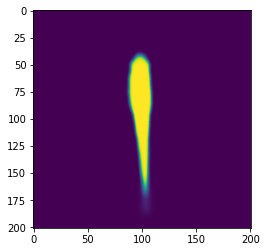

7


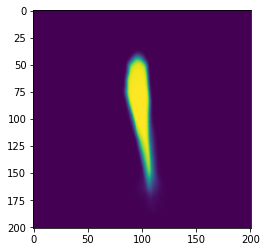

8


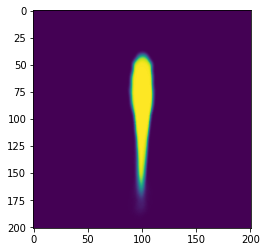

9


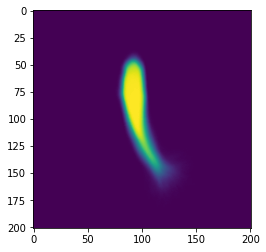

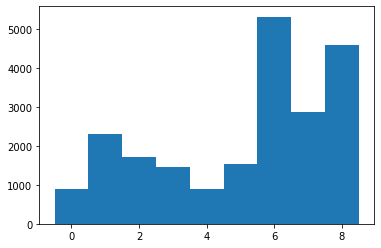

In [42]:

centers = centers.reshape(n_clusters,201,201)
for s, img in enumerate(centers):
    print(s)
    cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    plt.imshow(img)
    plt.show()
    
_, _, _ = plt.hist(labels, bins=np.arange(n_clusters)-0.5)

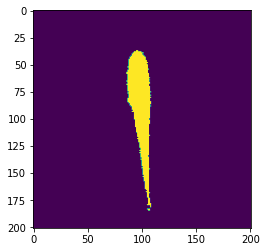

In [21]:

img = np.load(flist[334])
img = cutting_img(img, (120,120), 100)

sks = NT_skeleton(img)

v1 = sks[0]-sks[2]
a = v1/np.linalg.norm(v1, ord=2)
b = np.array([1,0])

#等邀三角只要知道第三邊長c就可以算出角度，但如要知道旋轉的方向則須判別兩向量正負號
#sin(angle) = a[1]b[0]-a[0]b[1]
c = a-b
angle = 2*np.arcsin(np.linalg.norm(c/2))
if a[1]>0:
    angle = -angle
if angle != angle:
    print("算錯啦")
    print(sks)
M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
rotated = cv2.warpAffine(img, M, (201,201))
plt.imshow(rotated>200)

In [27]:
for s, label in enumerate(labels):
    if label == 8:
        rot_imgs

dtype('bool')